<a href="https://colab.research.google.com/github/Jmmostafa/QuantRisk/blob/main/QR001_TermStructure.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Term Structure Models**

|  |  |
|:---|:---|
|**Developed By** |  Md Mostafa Kamal |
|**Date** | May 31, 2025  |
|**Covered** | Term Structure, Interpolation techniques, Application |
|**Sequence** | QR001 |


---

# Introduction

The term structure of interest rates (yield curve) describes the relationship between bond yields and their maturities. Since market data is often sparse, interpolation is used to estimate yields for missing maturities.


There are several methods used to interpolate. Key methods used are:

* Linear Interpolation
* Spline Interpolation
* Cubic Spline Interpolation
* Nelson-Siegel Model
* Bootstrapping Zero-Coupon Yields

# Data
For the demonstration purpose, we use 1 Month (lates) US treasury bills, notes, and data for implementing the methods. Replication can be done usign the following codes.

In [84]:
# Loading the required libraries
!pip install yfinance numpy scipy matplotlib scienceplots --quiet
!apt-get install texlive-latex-extra texlive-fonts-recommended dvipng cm-super --quiet
import yfinance as yf
import numpy as np
from scipy.interpolate import interp1d, CubicSpline
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Computer Modern Roman"],
    "text.latex.preamble": r"\usepackage{amsmath}"
})

Reading package lists...
Building dependency tree...
Reading state information...
cm-super is already the newest version (0.3.4-17).
dvipng is already the newest version (1.15-1.1).
texlive-fonts-recommended is already the newest version (2021.20220204-1).
texlive-latex-extra is already the newest version (2021.20220204-1).
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.


[*********************100%***********************]  4 of 4 completed


<Figure size 1000x600 with 0 Axes>

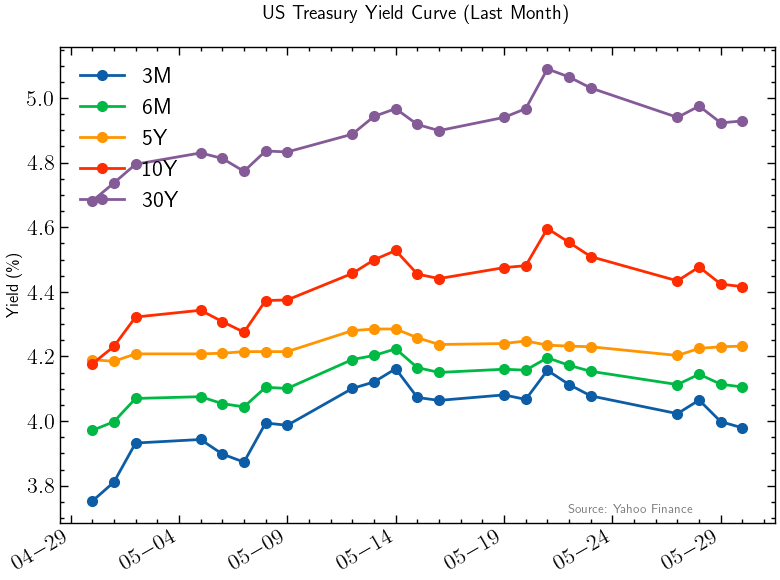

In [85]:
# Collecting the treasury yield data from Yahoo Finance
treasury_data = yf.download("^IRX ^FVX ^TNX ^TYX", period="1mo")['Close']
treasury_data.columns = ["3M", "5Y", "10Y", "30Y"]
# Add 6M yield (approximated from 3M and 5Y)
treasury_data["6M"] = (treasury_data["3M"] + treasury_data["5Y"]) / 2  # Simple average
treasury_data = treasury_data[["3M", "6M", "5Y", "10Y", "30Y"]]


# Plotting the data
import scienceplots  # Import before matplotlib
import matplotlib.pyplot as plt

plt.style.use(['science', 'notebook', 'grid'])
plt.figure(figsize=(10, 6), dpi=100)
plt.rcParams['text.usetex'] = True
ax = treasury_data.plot(linewidth=2, marker='o', markersize=7)
plt.title("US Treasury Yield Curve (Last Month)", fontsize=14, pad=20)
plt.xlabel("", fontsize=12)
plt.ylabel("Yield (\%)", fontsize=12)
plt.annotate("Source: Yahoo Finance",
             xy=(0.71, 0.02),
             xycoords='axes fraction',
             fontsize=9,
             color='gray')
plt.legend(frameon = False, loc = 'best')
ax.xaxis.set_major_locator(mdates.DayLocator(interval=5))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
plt.grid(False)
plt.tight_layout()
plt.show()

## 1. Linear Interpolation
Connects observed yields with straight lines between maturity points. Simplest method but can produce kinks.

**Formula**:  
For maturities $t_1$ and $t_2$ with yields $y_1$ and $y_2$:

$$
y(t) = y_1 + \frac{y_2 - y_1}{t_2 - t_1} (t - t_1)
$$

**Key Characteristics**:
- Fastest computation method
- Produces discontinuous derivatives at knot points
- Best for quick estimates when smoothness isn't critical

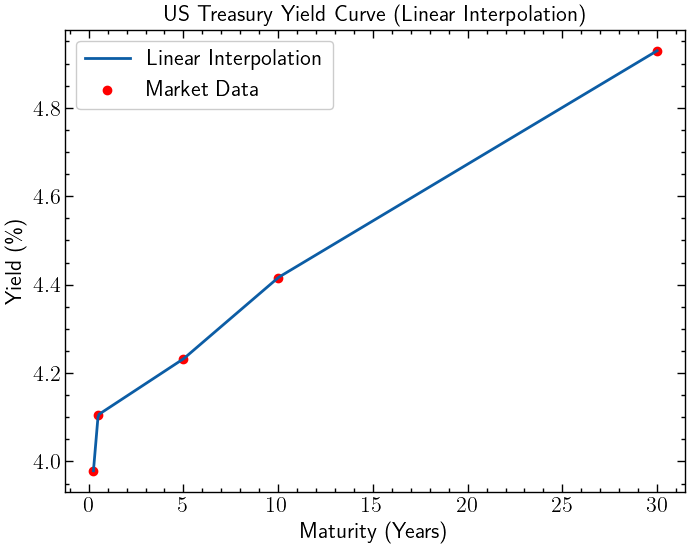

In [86]:
# Selecting samples
latest_yields = treasury_data.iloc[-1].values
maturities = np.array([0.25, 0.5, 5, 10, 30])  # 3M, 6M, 5Y, 10Y, 30Y

# Linear interpolation
linear_interp = interp1d(maturities, latest_yields, kind='linear')
t_new = np.linspace(min(maturities), max(maturities), 500)
plt.plot(t_new, linear_interp(t_new), label="Linear Interpolation")
plt.scatter(maturities, latest_yields, color='red', label="Market Data")
plt.title("US Treasury Yield Curve (Linear Interpolation)")
plt.xlabel("Maturity (Years)"); plt.ylabel("Yield (\%)"); plt.legend(); plt.grid(False)
plt.show()

## 2. Spline Interpolation
**Description**:  
Fits piecewise polynomials to achieve smoother curves than linear interpolation.

**Types**:
- **Natural Cubic Spline**: Enforces $S''(t) = 0$ at endpoints  
- **Hermite Spline**: Matches first derivatives at knots  

**General Formula**:  
For segment $t \in [t_i, t_{i+1}]$:

$$
S(t) = a_i + b_i(t-t_i) + c_i(t-t_i)^2 + d_i(t-t_i)^3
$$



### (a). Natural Cubic Spline
**Constraint**:
- Second derivatives at endpoints = 0 ($S''(t_0) = S''(t_n) = 0$)

**Piecewise Formula** (for interval $[t_i, t_{i+1}]$):
$$
S_i(t) = a_i + b_i(t-t_i) + c_i(t-t_i)^2 + d_i(t-t_i)^3
$$

**System of Equations**:
1. Continuity: $S_i(t_{i+1}) = S_{i+1}(t_{i+1})$
2. First derivative continuity: $S'_i(t_{i+1}) = S'_{i+1}(t_{i+1})$
3. Second derivative continuity: $S''_i(t_{i+1}) = S''_{i+1}(t_{i+1})$
4. Natural boundary: $S''(t_0) = S''(t_n) = 0$


**Pros**:  
✓ Maximally smooth (continuous 2nd derivatives)  
✓ Excellent for visualizations  
✓ Stable with sparse data  

**Cons**:  
✗ May produce oscillatory artifacts ("overshooting")  
✗ Not guaranteed arbitrage-free  
✗ Less local control than Hermite  

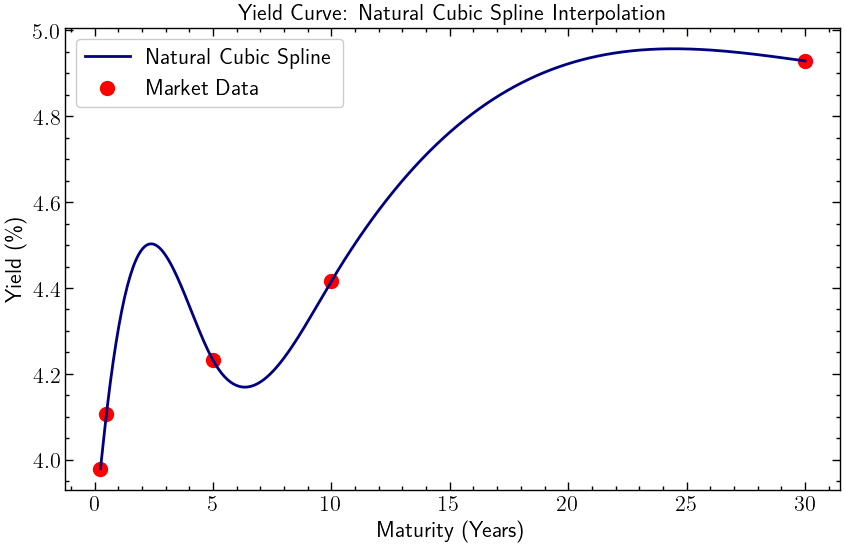

In [87]:
import numpy as np
from scipy.interpolate import CubicSpline
import matplotlib.pyplot as plt

# Treasury yield data (3M, 6M, 5Y, 10Y, 30Y)
maturities = np.array([0.25, 0.5, 5, 10, 30])  # in years
latest_yields = treasury_data.iloc[-1].values

# Natural cubic spline (second derivatives set to zero at endpoints)
cs = CubicSpline(maturities, latest_yields, bc_type='natural')

# Generate smooth curve
t_new = np.linspace(min(maturities), max(maturities), 500)
y_spline = cs(t_new)

# Plot
plt.figure(figsize=(10, 6))
plt.plot(t_new, y_spline, label="Natural Cubic Spline", color='navy')
plt.scatter(maturities, latest_yields, color='red', s=100, label="Market Data")
plt.title("Yield Curve: Natural Cubic Spline Interpolation")
plt.xlabel("Maturity (Years)")
plt.ylabel("Yield (\%)")
plt.legend()
plt.grid(False)
plt.show()

### (b). Hermite Spline
A piecewise cubic polynomial that interpolates both function values *and their derivatives* at given knots.

**Constraint**:
- Matches first derivatives $S'(t_i)$ at knots


**Piecewise Formula** (for interval $[t_i, t_{i+1}]$):
$$
S_i(t) = y_i + y'_i(t-t_i) + \left[\frac{3(y_{i+1}-y_i)}{h_i} - 2y'_i - y'_{i+1}\right](t-t_i)^2 + \left[\frac{2(y_i-y_{i+1})}{h_i} + y'_i + y'_{i+1}\right](t-t_i)^3
$$

Where:
- $h_i = t_{i+1} - t_i$
- $y'_i$ = first derivative at knot $t_i$
- $y_i$ = observed yield at $t_i$


**Pros**:  
✓ Preserves local shape (matches user-defined slopes)  
✓ Better control via derivative inputs  
✓ More stable than natural spline for financial data  

**Cons**:  
✗ Requires slope estimates (sensitive to errors)  
✗ Less smooth than natural spline (only \( C^1 \) continuous)  
✗ Complex implementation  

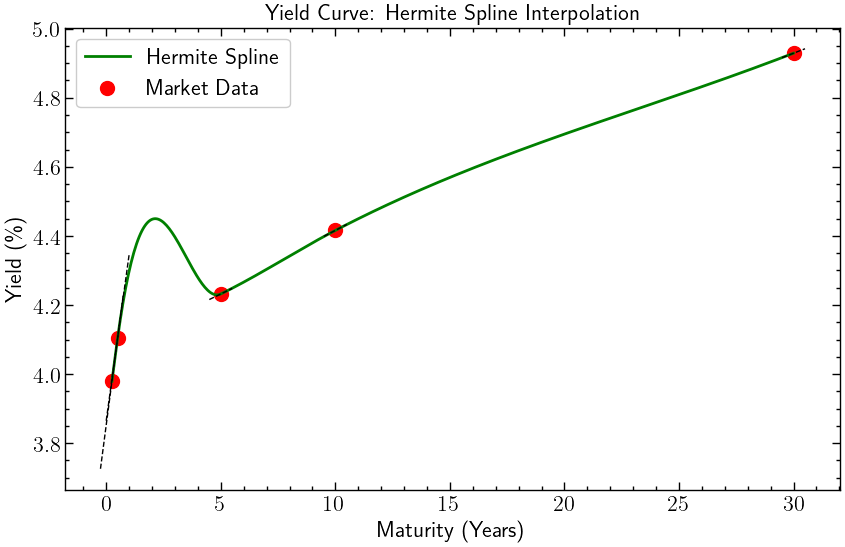

In [88]:
from scipy.interpolate import CubicHermiteSpline

# Calculate approximate derivatives (slopes) at each point
# Using finite differences for demonstration
dy = np.gradient(latest_yields, maturities)

# Hermite spline interpolation
hermite = CubicHermiteSpline(maturities, latest_yields, dy)

# Generate smooth curve
y_hermite = hermite(t_new)

# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot(t_new, y_hermite, label="Hermite Spline", color='green')
plt.scatter(maturities, latest_yields, color='red', s=100, label="Market Data")
for x, y, d in zip(maturities, latest_yields, dy):
    dx = 0.5  # length of tangent line segment
    plt.plot([x-dx, x+dx], [y-dx*d, y+dx*d], 'k--', linewidth=1)
plt.title("Yield Curve: Hermite Spline Interpolation")
plt.xlabel("Maturity (Years)")
plt.ylabel("Yield (\%)")
plt.legend()
plt.grid(False)
plt.show()

## 3. Nelson-Siegel Model (1987)
**Description**:  
3-factor parametric model capturing level, slope, and curvature of yield curves.
* **Pros:** Parametric, economically meaningful factors
* **Cons:** Requires nonlinear optimization

**Formula**:

$$
y(t) = \beta_0 + \beta_1 \left( \frac{1 - e^{-\lambda t}}{\lambda t} \right) + \beta_2 \left( \frac{1 - e^{-\lambda t}}{\lambda t} - e^{-\lambda t} \right)
$$

**Parameters**:
- $\beta_0$: Long-term rate (level)  
- $\beta_1$: Short-term component (slope)  
- $\beta_2$: Medium-term curvature  
- $\lambda$: Decay rate (typically ~0.5)  

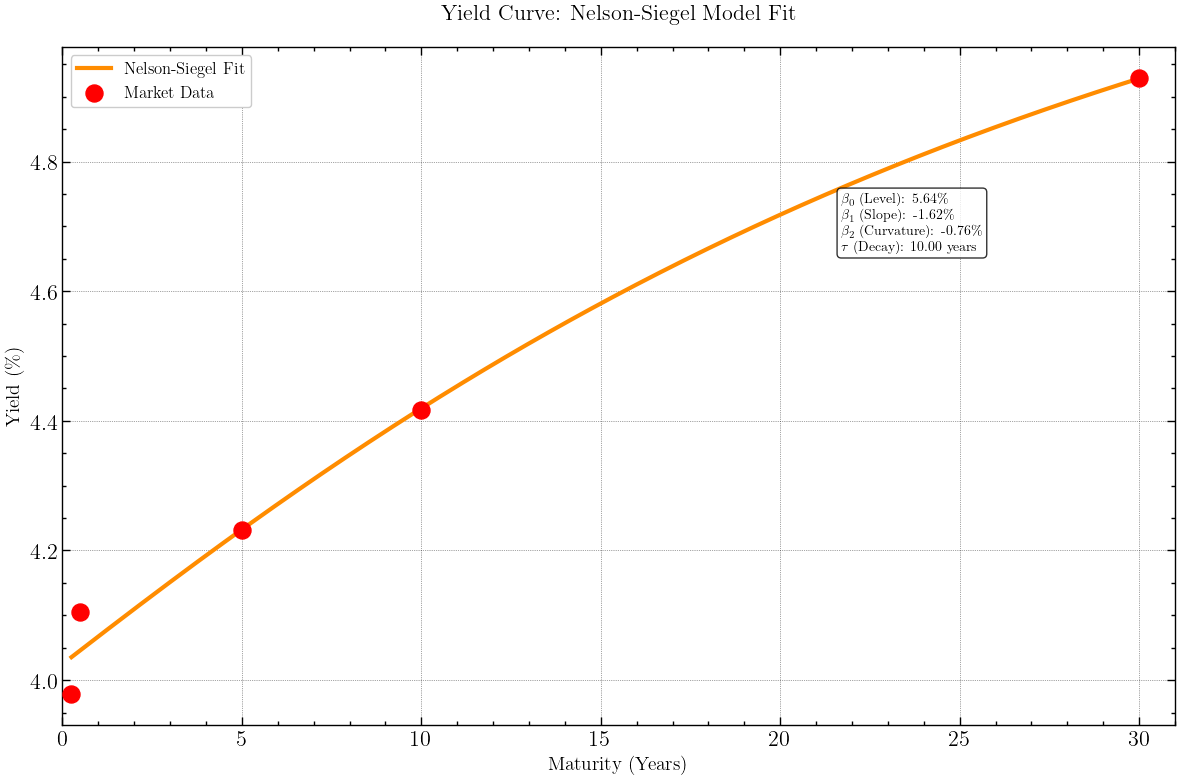

In [102]:
# Nelson-Siegel model function
def nelson_siegel(t, beta0, beta1, beta2, tau):
    """Nelson-Siegel yield curve model"""
    t = np.maximum(t, 0.0001)  # Avoid division by zero
    factor = t/tau
    factor1 = (1 - np.exp(-factor)) / factor
    factor2 = factor1 - np.exp(-factor)
    return beta0 + beta1*factor1 + beta2*factor2

# Initial parameter guesses
initial_guess = [3.0, -2.0, 1.0, 1.0]  # [beta0, beta1, beta2, tau]

# Fit the model
params, _ = curve_fit(nelson_siegel,
                     maturities,
                     latest_yields,
                     p0=initial_guess,
                     bounds=([0, -np.inf, -np.inf, 0.1],
                            [10, np.inf, np.inf, 10]))

# Generate fitted curve
t_new = np.linspace(min(maturities), max(maturities), 500)
fitted_yields = nelson_siegel(t_new, *params)

# Plot results
plt.figure(figsize=(12, 8))
plt.plot(t_new, fitted_yields, label=r"Nelson-Siegel Fit", color='darkorange', linewidth=3)
plt.scatter(maturities, latest_yields, color='red', s=150, label=r"Market Data", zorder=5)

# Annotate parameters with proper LaTeX math
param_text = (
    r"$\beta_0$ (Level): " + f"{params[0]:.2f}\%\n" +
    r"$\beta_1$ (Slope): " + f"{params[1]:.2f}\%\n" +
    r"$\beta_2$ (Curvature): " + f"{params[2]:.2f}\%\n" +
    r"$\tau$ (Decay): " + f"{params[3]:.2f} years"
)
plt.annotate(param_text,
            xy=(0.7, 0.7),
            xycoords='axes fraction',
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.8),
            fontsize=10)

# Formatting with LaTeX
plt.title(r"Yield Curve: Nelson-Siegel Model Fit", fontsize=16, pad=20)
plt.xlabel(r"Maturity (Years)", fontsize=14)
plt.ylabel(r"Yield (\%)", fontsize=14)
plt.legend(fontsize=12)
plt.grid(True, linestyle=':', alpha=0.7)

# Highlight short-term and long-term behavior
plt.annotate(r"Short-term rates driven by $\beta_1$",
            xy=(0.5, params[0] + params[1] - 0.2),
            xytext=(2, params[0] + params[1] - 0.5),
            arrowprops=dict(arrowstyle="->"),
            fontsize=10)

plt.annotate(r"Long-term rate $\rightarrow \beta_0$",
            xy=(25, params[0] + 0.1),
            xytext=(20, params[0] - 0.5),
            arrowprops=dict(arrowstyle="->"),
            fontsize=10)

plt.xlim(0, 31)
plt.tight_layout()
plt.show()

## 4. Linear-on-Log-Discount-Factors Interpolation
**Method**:  
Interpolates linearly on the natural log of discount factors, then converts back to yields.

**Key Formulas**:
1. Discount factor:  
   $$
   DF(t) = e^{-y(t) \cdot t}
   $$
2. Log transformation:  
   $$
   \ln DF(t) = -y(t) \cdot t
   $$
3. Linear interpolation:  
   $$
   \ln DF(t)_{\text{interp}} = \text{interp1d}(t, \ln DF(t))
   $$
4. Back to yields:  
   $$
   y(t) = -\frac{\ln DF(t)_{\text{interp}}}{t}
   $$

**Pros**:  
✓ Guarantees positive interest rates  
✓ Preserves no-arbitrage conditions  
✓ Simple implementation  

**Cons**:  
✗ Less smooth than spline methods  
✗ Requires careful short-term extrapolation  
✗ May over-flatten the long end  

**Best For**:  
- Derivatives pricing  
- Risk-neutral valuation  
- Short-term yield curve modeling  


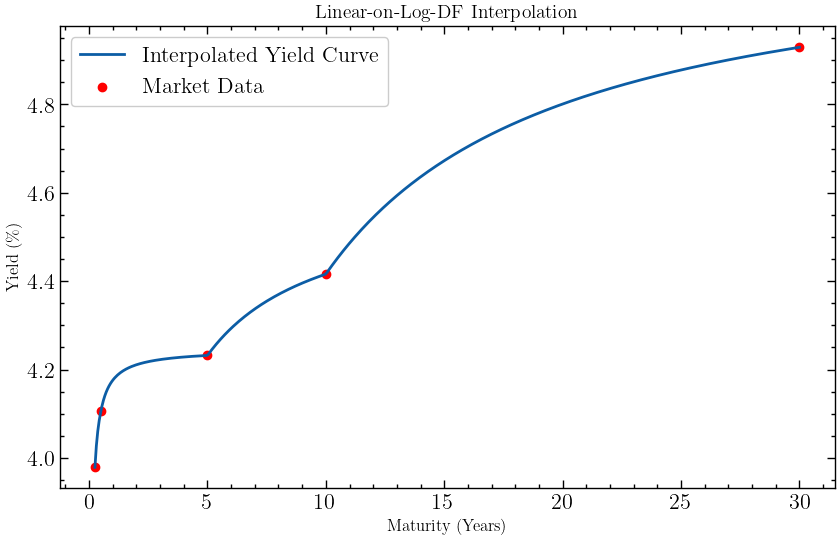

In [95]:
import numpy as np
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt

# Market data
maturities = np.array([0.25, 0.5, 5, 10, 30])  # in years
latest_yields = treasury_data.iloc[-1].values

# Calculate discount factors
discount_factors = np.exp(-maturities * latest_yields/100)
log_dfs = np.log(discount_factors)

# Create interpolation function with bounds handling
interp = interp1d(maturities, log_dfs,
                 kind='linear',
                 fill_value='extrapolate')  # Allow extrapolation

# Generate points (now including t < 0.25)
t_new = np.linspace(min(maturities), max(maturities), 500)

# Calculate interpolated yields with boundary checks
with np.errstate(divide='ignore', invalid='ignore'):
    interp_log_dfs = interp(t_new)
    interp_yields = -interp_log_dfs / t_new * 100

    # Handle t=0 case (instantaneous forward rate)
    interp_yields[t_new == 0] = latest_yields[0]  # Use shortest maturity yield

# Plot results
plt.figure(figsize=(10, 6))
plt.rcParams['text.usetex'] = True
plt.plot(t_new, interp_yields, label="Interpolated Yield Curve")
plt.scatter(maturities, latest_yields, color='red', label="Market Data")
plt.title("Linear-on-Log-DF Interpolation", fontsize=14)
plt.xlabel("Maturity (Years)", fontsize=12)
plt.ylabel("Yield (\%)", fontsize=12)
plt.legend()
plt.grid(False)
plt.show()

# Combining the Models

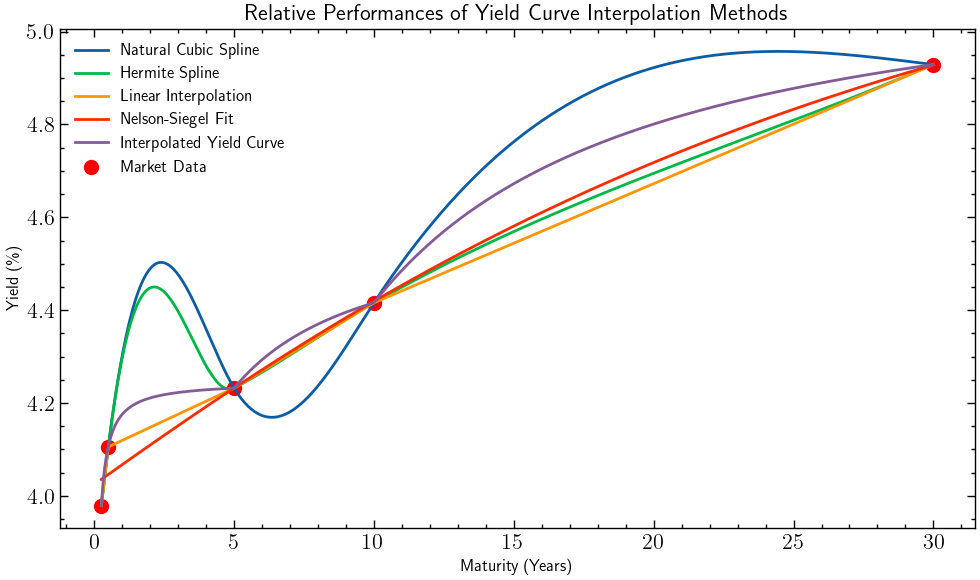

In [96]:
import scienceplots
import matplotlib.pyplot as plt

plt.style.use(['science', 'notebook', 'grid'])
plt.figure(figsize=(10, 6), dpi=100)
plt.rcParams['text.usetex'] = True
plt.plot(t_new, y_spline, label="Natural Cubic Spline", linewidth=2)
plt.plot(t_new, y_hermite, label="Hermite Spline", linewidth=2)
plt.plot(t_new, linear_interp(t_new), label="Linear Interpolation", linewidth=2)
plt.plot(t_new, nelson_siegel(t_new, *params), label="Nelson-Siegel Fit", linewidth=2)
plt.plot(t_new, interp_yields, label="Interpolated Yield Curve", linewidth=2)
plt.scatter(maturities, latest_yields, color='red', s=100, label="Market Data")
plt.title("Relative Performances of Yield Curve Interpolation Methods")
plt.xlabel("Maturity (Years)",fontsize = 12)
plt.ylabel("Yield (\%)", fontsize = 12)
plt.legend(frameon = False,fontsize = 12)
plt.grid(False)
plt.tight_layout()
plt.show()

# **References**

- Kleinmichel, H. (1970). JH Ahlberg, EN Nilson, JL Walsh, The Theory of Splines and Their Applications.(Mathematics in Science and Engineering, Volume 38.) XI+ 284 S. New York/London 1967. Academic Press. Preis geb. $13.50. Zeitschrift Angewandte Mathematik und Mechanik, 50(6), 441-442.
- Nelson, C. R., & Siegel, A. F. (1987). Parsimonious modeling of yield curves. Journal of business, 473-489.